## S-1: Data setup and validation

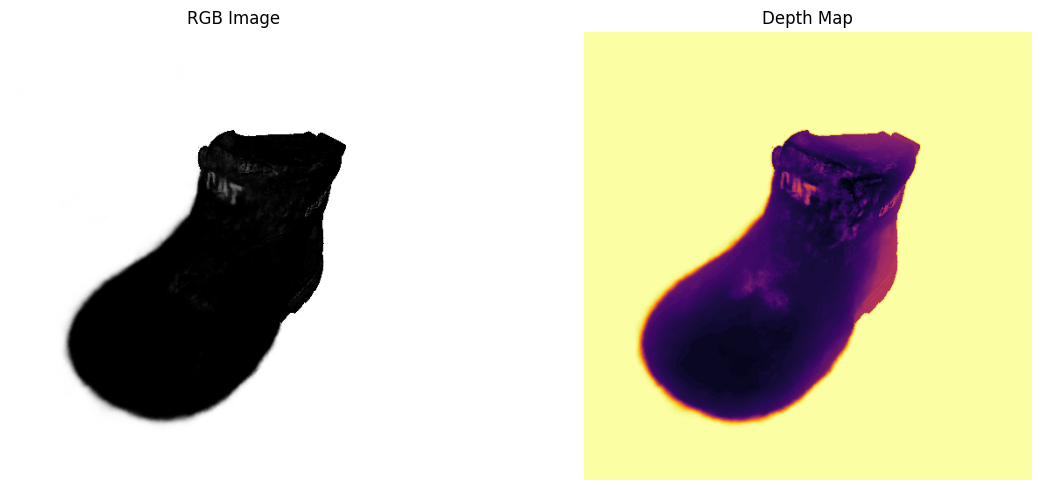

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# === Path to your renders directory and transforms.json ===
dataset_root = "/Users/surgitm/Desktop/renders"
json_path = os.path.join(dataset_root, "transforms.json")

# === Load NeRF-style camera metadata ===
with open(json_path, "r") as f:
    meta = json.load(f)

# === Pick the first sample ===
sample = meta['frames'][0]

# Extract relative path (e.g., 'rgb/image_000000.png') and remove extension
relative_file_path = sample['file_path']
base_name_no_ext = os.path.splitext(os.path.basename(relative_file_path))[0]  # 'image_000000'

# === Construct full paths to RGB and Depth ===
img_path = os.path.join(dataset_root, "rgb", base_name_no_ext + ".jpg")
depth_path = os.path.join(dataset_root, "expected_depth", base_name_no_ext + ".jpg")

# === Load the RGB image ===
image = np.array(Image.open(img_path))

# === Load the depth map as grayscale and normalize to [0, 1] ===
depth_img = Image.open(depth_path).convert("L")
depth = np.array(depth_img).astype(np.float32) / 255.0

# === Visualize both ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth, cmap='inferno')
plt.title("Depth Map")
plt.axis("off")
plt.tight_layout()
plt.show()


## S-2: Convert RGB + Depth → 3D Point Cloud

In [3]:
import open3d as o3d

# === Step 2a: Convert PIL images to Open3D format ===
rgb_o3d = o3d.geometry.Image((image).astype(np.uint8))
depth_o3d = o3d.geometry.Image((depth * 255).astype(np.uint8))  # scale back for 8-bit

# === Step 2b: Create RGBD image ===
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color=rgb_o3d,
    depth=depth_o3d,
    depth_scale=255.0,  # must match your earlier normalization
    convert_rgb_to_intensity=False
)

# === Step 2c: Create pinhole camera intrinsic (assume 64x64 fx/fy or fetch from metadata if available) ===
width, height = image.shape[1], image.shape[0]
fx = fy = max(width, height)  # rough focal length guess; adjust if known
cx = width / 2
cy = height / 2
intrinsics = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

# === Step 2d: Create Point Cloud ===
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    intrinsics
)

# === Step 2e: Flip for Open3D coordinate compatibility ===
pcd.transform([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 0],
               [0, 0, 0, 1]])

# === Step 2f: Visualize ===
o3d.visualization.draw_geometries([pcd], window_name="NeRFiller Point Cloud")


In [5]:
# === Save the generated point cloud to PLY ===

output_pcd_path = "/Users/surgitm/Desktop/renders/nerfiller_pointcloud.ply"
o3d.io.write_point_cloud(output_pcd_path, pcd)
print(f"✅ Saved point cloud to: {output_pcd_path}")


✅ Saved point cloud to: /Users/surgitm/Desktop/renders/nerfiller_pointcloud.ply


## S-3: Align NeRF Point Cloud with the Partial Mesh

In [7]:
import open3d as o3d

# === Load the partial mesh ===
partial_mesh_path = "/Users/surgitm/Desktop/partial_boot.obj"
partial_mesh = o3d.io.read_triangle_mesh(partial_mesh_path)

# Validate if mesh was read properly
if not partial_mesh.has_triangles():
    raise RuntimeError("❌ Mesh has no triangles. Please check the file content.")

# Optional: Compute normals if needed
partial_mesh.compute_vertex_normals()

# === Convert to point cloud ===
partial_pcd = partial_mesh.sample_points_uniformly(number_of_points=3000)

# ✅ Ready for alignment or visualization
o3d.visualization.draw_geometries([partial_pcd], window_name="Partial Mesh Point Cloud")


## S-4: Fuse and Clean the Combined Point Cloud

In [19]:
print("Partial:", np.asarray(partial_pcd.points).shape)


Partial: (3000, 3)


In [21]:
partial_mesh_path = "/Users/surgitm/Desktop/partial_boot.obj"
assert os.path.exists(partial_mesh_path), "File not found!"


In [34]:
import open3d as o3d

# Load mesh
partial_mesh = o3d.io.read_triangle_mesh(partial_mesh_path)
partial_mesh.compute_vertex_normals()

# Check if mesh has triangles
print("Has triangles:", partial_mesh.has_triangles())

# Sample uniformly if valid
if partial_mesh.has_triangles():
    partial_pcd = partial_mesh.sample_points_uniformly(number_of_points=3000)
    print("Partial:", np.asarray(partial_pcd.points).shape)
    o3d.visualization.draw_geometries([partial_pcd], window_name="✅ Partial Mesh Point Cloud")
else:
    print("❌ Mesh has no triangles! Check .obj content.")


Has triangles: True
Partial: (3000, 3)


In [1]:
# === STEP 4: Fuse and Clean Combined Point Cloud ===

# Combine both point clouds
combined_pcd = partial_pcd + nerf_pcd

# Optional: Downsample to reduce noise and density
combined_pcd = combined_pcd.voxel_down_sample(voxel_size=0.003)

# Optional: Estimate normals (required for mesh reconstruction)
combined_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))

# Visualize
o3d.visualization.draw_geometries([combined_pcd], window_name="🌀 Fused Point Cloud")

# Save to disk
output_combined_path = "/Users/surgitm/Desktop/renders/combined_pointcloud.ply"
o3d.io.write_point_cloud(output_combined_path, combined_pcd)
print(f"✅ Fused point cloud saved to: {output_combined_path}")


NameError: name 'partial_pcd' is not defined

In [27]:
print("Partial PCD points:", np.asarray(partial_pcd.points).shape)
print("NeRF PCD points:", np.asarray(nerf_pcd.points).shape)

partial_center = partial_pcd.get_center()
nerf_center = nerf_pcd.get_center()
print("Partial center:", partial_center)
print("NeRF center:", nerf_center)

translation_vector = nerf_center - partial_center
print("Suggested translation from partial → nerf:", translation_vector)


Partial PCD points: (3000, 3)


NameError: name 'nerf_pcd' is not defined

## S-5: Poisson Reconstruction

In [17]:
# Reload point cloud
pcd = o3d.io.read_point_cloud("/Users/surgitm/Desktop/renders/combined_pointcloud.ply")

# Estimate and orient normals
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
pcd.orient_normals_consistent_tangent_plane(k=10)

# Visualize with normals
o3d.visualization.draw_geometries([pcd], point_show_normal=True, window_name="🧭 Normals Check")


In [19]:
import open3d as o3d

# Load the combined point cloud again
combined_path = "/Users/surgitm/Desktop/renders/combined_pointcloud.ply"
pcd = o3d.io.read_point_cloud(combined_path)

# === Step 1: Remove outliers (Statistical) ===
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
clean_pcd = pcd.select_by_index(ind)

# === Step 2: Estimate normals (for Poisson) ===
clean_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.02, max_nn=60))
clean_pcd.orient_normals_consistent_tangent_plane(100)

# Visualize cleaned point cloud
o3d.visualization.draw_geometries([clean_pcd], window_name="🧼 Cleaned Point Cloud")

# === Step 3: Poisson reconstruction ===
print("🔄 Running improved Poisson surface reconstruction...")
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(clean_pcd, depth=9)
print("✅ Reconstruction complete.")

# Optional: crop floating mesh parts based on density threshold
density_threshold = np.percentile(densities, 10)  # Keep top 90% dense
vertices_to_keep = densities > density_threshold
mesh = mesh.select_by_index(np.where(vertices_to_keep)[0])

# Visualize
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True, window_name="🔧 Cleaned Poisson Mesh")

# Save
poisson_mesh_path = "/Users/surgitm/Desktop/renders/poisson_mesh_cleaned.ply"
o3d.io.write_triangle_mesh(poisson_mesh_path, mesh)
print(f"✅ Cleaned Poisson mesh saved to: {poisson_mesh_path}")


🔄 Running improved Poisson surface reconstruction...
✅ Reconstruction complete.
[Open3D WARNING] Write Ply clamped color value to valid range
✅ Cleaned Poisson mesh saved to: /Users/surgitm/Desktop/renders/poisson_mesh_cleaned.ply


In [1]:
import open3d as o3d
import numpy as np

# Load combined point cloud
combined_pcd = o3d.io.read_point_cloud("/Users/surgitm/Desktop/renders/combined_pointcloud.ply")

# === STEP 5: Preprocessing ===

# Normalize for better numerical stability
scale = 1 / np.max(combined_pcd.get_max_bound() - combined_pcd.get_min_bound())
combined_pcd.scale(scale, center=combined_pcd.get_center())

# Recompute normals
combined_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
combined_pcd.orient_normals_consistent_tangent_plane(30)

# === STEP 5a: Poisson Reconstruction ===

print("🔄 Running Poisson surface reconstruction...")
poisson_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(combined_pcd, depth=9)

# Save raw Poisson mesh
raw_poisson_path = "/Users/surgitm/Desktop/renders/raw_poisson_mesh.ply"
o3d.io.write_triangle_mesh(raw_poisson_path, poisson_mesh)
print(f"✅ Raw Poisson mesh saved to: {raw_poisson_path}")

# OPTIONAL: Filter out low-density vertices (visually check before applying)
print("📉 Removing low-density vertices...")
densities = np.asarray(densities)
threshold = np.quantile(densities, 0.01)
vertices_to_keep = densities > threshold
poisson_mesh.remove_vertices_by_mask(~vertices_to_keep)

# Save cleaned mesh
cleaned_mesh_path = "/Users/surgitm/Desktop/renders/poisson_mesh.ply"
o3d.io.write_triangle_mesh(cleaned_mesh_path, poisson_mesh)
print(f"✅ Cleaned Poisson mesh saved to: {cleaned_mesh_path}")

# Visualize
o3d.visualization.draw_geometries([poisson_mesh], window_name="🎯 Cleaned Poisson Mesh")


🔄 Running Poisson surface reconstruction...
[Open3D WARNING] Write Ply clamped color value to valid range
✅ Raw Poisson mesh saved to: /Users/surgitm/Desktop/renders/raw_poisson_mesh.ply
📉 Removing low-density vertices...
[Open3D WARNING] Write Ply clamped color value to valid range
✅ Cleaned Poisson mesh saved to: /Users/surgitm/Desktop/renders/poisson_mesh.ply


## S-6: Ball Pivoting

In [29]:
import numpy as np
import open3d as o3d

# Load cleaned point cloud from Step 4 (or reuse `combined_pcd` directly if in memory)
combined_pcd = o3d.io.read_point_cloud("/Users/surgitm/Desktop/renders/combined_pointcloud.ply")

# === 1. Estimate normals + orient consistently ===
combined_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
combined_pcd.orient_normals_consistent_tangent_plane(k=10)

# === 2. Compute average nearest-neighbor distance to adapt radius ===
distances = combined_pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist  # Empirical multiplier

print(f"🔧 Using ball pivoting radius: {radius:.5f}")

# === 3. Run Ball Pivoting ===
radii = o3d.utility.DoubleVector([radius])
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    combined_pcd,
    o3d.utility.DoubleVector([radius, radius * 1.5])  # you can experiment with more
)

# === 4. Clean the mesh ===
mesh.remove_degenerate_triangles()
mesh.remove_duplicated_triangles()
mesh.remove_non_manifold_edges()

# Optional smoothing can be added here using mesh filters

# === 5. Visualize final mesh ===
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True, window_name="✅ Final Reconstructed Mesh")

# === 6. Export mesh ===
output_path = "/Users/surgitm/Desktop/box/final_mesh_bpa.ply"
o3d.io.write_triangle_mesh(output_path, mesh)
print(f"✅ Final mesh saved to: {output_path}")


🔧 Using ball pivoting radius: 0.06922
✅ Final mesh saved to: /Users/surgitm/Desktop/box/final_mesh_bpa.ply
